# Diagnosis of Heart Disease
Group Members: Jimmy Hu, Jiajie Yuan, Shan He <p>
Data Source: <https://www.kaggle.com/ronitf/heart-disease-uci>

## Part I. Introduction
The great role of machine learning in the field of disease diagnosis comes from its capability to predict outcomes with high dimensional patterns, where human beings have huge limitations. The goal of the group project is to apply machine learning models on heart disease dataset and make predictions. You will see the following six methods: k nearest neighbor classification, logistic regression, support vector classification, decision tree, random forest, and gradient boosting classification. This report contains five important parts, including description, data processing, statistical analysis and data visualization, and model application. 

## Part II. Description

### Attribute Information:
- age: The person's age in years
- sex: The person's sex (1 = male, 0 = female)
- cp: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- trestbps: The person's resting blood pressure (mm Hg on admission to the hospital)
- chol: The person's cholesterol measurement in mg/dl
- fbs: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)
- restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- thalach: The person's maximum heart rate achieved
- exang: Exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)
- slope: the slope of the peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping)
- ca: The number of major vessels (0-3)
- thal: A blood disorder called thalassemia (1 = normal; 2 = fixed defect; 3 = reversable defect)
- target: Heart disease (0 = no, 1 = yes)

## Part III. Data Processing and Model Application
### Step One: Load Tools

In [2]:
# import basic modules
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image  
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# import ML model here
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# shut down warning massages
import warnings
warnings.filterwarnings("ignore")

# set random seed
RANDOM_SEED = 42

### Step Two: Function Definition

In [3]:
class Model(object):
    def __init__(self, model, random_state=42):
        # class or str are both valid
        self._model_name = model if type(model) is str else model.__name__
        self._model = Pipeline([('scaler', StandardScaler()),
                                ('model', eval(model)() if type(model) is str else model())])
        self._random_state = random_state

    def grid_search(self, param_grid, ds, display_val=False):
        # 70% for training, 10% for validating
        param_grid = param_grid.copy()
        kflod = StratifiedKFold(n_splits=8, shuffle=True, random_state=self._random_state)
        for key in list(param_grid.keys()): param_grid['model__%s'%key] = param_grid.pop(key)
        try: 
            search = RandomizedSearchCV(self._model, param_grid, n_jobs=-1, cv=kflod, n_iter=40)
            search.fit(ds['X_train'], ds['y_train'])
        except ValueError: 
            search = GridSearchCV(self._model, param_grid, n_jobs=-1, cv=kflod)
            search.fit(ds['X_train'], ds['y_train'])
            
        # record the best model for testing
        self._best_params_ = search.best_params_
        self._best_score = search.best_score_
        self._best_estimator_ = search.best_estimator_
        for key in list(self._best_params_.keys()):
            self._best_params_[key.replace('model__', '')] = self._best_params_.pop(key)
            
        # display validation scores
        if display_val: 
            param_col = ['param_%s'%i for i in list(param_grid.keys())]
            col = ['rank_test_score', 'mean_test_score'] + param_col
            score_table = pd.DataFrame(search.cv_results_)[col].sort_values('rank_test_score')
            for col_name in score_table.columns:
                score_table[col_name.replace('param_model__', '')] = score_table.pop(col_name)
            col = [col_name.replace('param_model__', '') for col_name in col]
            score_table.columns = [[self._model_name+': '+str(self._best_params_)]*len(col), col]
            display(score_table.head(5))
        else:
            print('  %s:'%self._model_name, self._best_params_)
        
    def get_model(self):
        try: return self._best_estimator_
        except NameError: return self._model()
    
    def get_best_params(self):
        try: return self._best_params_
        except NameError: return None
        
    def get_test_score(self, ds):
        # return both model name and its test score
        score_test = round(self._best_estimator_.score(ds['X_test'], ds['y_test']), 3)
        score_train = round(self._best_score, 3)
        name = self._model_name
        best_params = str(self._best_estimator_).replace("'", '')
        return name, score_test, score_train
    
    def get_name(self):
        return self._model_name

### Step Three: Load Data and Statistical Analysis

__1. Load Data__

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/ZijingHu/kaggle_heart_disease/master/heart.csv')
# display original dataset
data = data.ix[data['ca']<4, :]
data = data.ix[data['thal']>0, :]
display(data.head(), data.describe().iloc[[0, 3, -1]])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0
min,29.0,0.0,0.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,0.0,0.0,1.0,0.0
max,77.0,1.0,3.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,2.0,3.0,3.0,1.0


__2. Categorical Variable Tranformation__

In [5]:
# fix column names
data.columns=["age","sex","chest_pain_experienced","resting_blood_pressure","cholesterol_measurement",
              "fasting_blood_sugar","resting_electrocardiographic_measurement","maximum_heart_rate",
              "exercise_induced_angina","st_depression","peak_exercise_slope","number_of_major_vessels",
              "thalassemia","target"]

# categorical to dummy
data['sex'][data['sex']==0]='female'
data['sex'][data['sex']==1]='male'

data['chest_pain_experienced'][data['chest_pain_experienced']==0]='typical angina'
data['chest_pain_experienced'][data['chest_pain_experienced']==1]='atypical angina'
data['chest_pain_experienced'][data['chest_pain_experienced']==2]='non-anginal pain'
data['chest_pain_experienced'][data['chest_pain_experienced']==3]='asymptomatic'

data['fasting_blood_sugar'][data['fasting_blood_sugar']==0]='lower than 120mg/ml'
data['fasting_blood_sugar'][data['fasting_blood_sugar']==1]='higher than 120mg/ml'

data['resting_electrocardiographic_measurement'][data['resting_electrocardiographic_measurement']==0]='normal'
data['resting_electrocardiographic_measurement'][data['resting_electrocardiographic_measurement']==1]='ST-T wave abnormality'
data['resting_electrocardiographic_measurement'][data['resting_electrocardiographic_measurement']==2]='left ventricular hypertrophy'

data['exercise_induced_angina'][data['exercise_induced_angina']==0]='no'
data['exercise_induced_angina'][data['exercise_induced_angina']==1]='yes'

data['peak_exercise_slope'][data['peak_exercise_slope']==0]='upsloping'
data['peak_exercise_slope'][data['peak_exercise_slope']==1]='flat'
data['peak_exercise_slope'][data['peak_exercise_slope']==2]='downsloping'

data['thalassemia'][data['thalassemia'] == 1] = 'normal'
data['thalassemia'][data['thalassemia'] == 2] = 'fixed defect'
data['thalassemia'][data['thalassemia'] == 3] = 'reversable defect'

data.head()

,age,sex,chest_pain_experienced,resting_blood_pressure,cholesterol_measurement,fasting_blood_sugar,resting_electrocardiographic_measurement,maximum_heart_rate,exercise_induced_angina,st_depression,peak_exercise_slope,number_of_major_vessels,thalassemia,target
0,63,male,asymptomatic,145,233,higher than 120mg/ml,normal,150,no,2.3,upsloping,0,normal,1
1,37,male,non-anginal pain,130,250,lower than 120mg/ml,ST-T wave abnormality,187,no,3.5,upsloping,0,fixed defect,1
2,41,female,atypical angina,130,204,lower than 120mg/ml,normal,172,no,1.4,downsloping,0,fixed defect,1
3,56,male,atypical angina,120,236,lower than 120mg/ml,ST-T wave abnormality,178,no,0.8,downsloping,0,fixed defect,1
4,57,female,typical angina,120,354,lower than 120mg/ml,ST-T wave abnormality,163,yes,0.6,downsloping,0,fixed defect,1


__3. Getting Dummy Variables__

In [6]:
data_final = pd.get_dummies(data, drop_first=True)
display(data_final.head(), data_final.describe(), data_final.shape)

# get variable names
Y_NAME = 'target'
X_NAME = [x for x in data_final.columns if x != Y_NAME]

,age,resting_blood_pressure,cholesterol_measurement,maximum_heart_rate,st_depression,number_of_major_vessels,target,sex_male,chest_pain_experienced_atypical angina,chest_pain_experienced_non-anginal pain,chest_pain_experienced_typical angina,fasting_blood_sugar_lower than 120mg/ml,resting_electrocardiographic_measurement_left ventricular hypertrophy,resting_electrocardiographic_measurement_normal,exercise_induced_angina_yes,peak_exercise_slope_flat,peak_exercise_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,0,0,0,0,1,0,0,1,1,0
1,37,130,250,187,3.5,0,1,1,0,1,0,1,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,1,0,0,1,0,1,0,0,0,0,0
3,56,120,236,178,0.8,0,1,1,1,0,0,1,0,0,0,0,0,0,0
4,57,120,354,163,0.6,0,1,0,0,0,1,1,0,0,1,0,0,0,0


,age,resting_blood_pressure,cholesterol_measurement,maximum_heart_rate,st_depression,number_of_major_vessels,target,sex_male,chest_pain_experienced_atypical angina,chest_pain_experienced_non-anginal pain,chest_pain_experienced_typical angina,fasting_blood_sugar_lower than 120mg/ml,resting_electrocardiographic_measurement_left ventricular hypertrophy,resting_electrocardiographic_measurement_normal,exercise_induced_angina_yes,peak_exercise_slope_flat,peak_exercise_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
count,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,131.60473,247.155405,149.560811,1.059122,0.679054,0.540541,0.679054,0.165541,0.280405,0.476351,0.85473,0.013514,0.489865,0.327703,0.462838,0.070946,0.060811,0.388514
std,9.059471,17.72662,51.977011,22.970792,1.166474,0.939726,0.499198,0.467631,0.372297,0.449958,0.500286,0.35297,0.115655,0.500744,0.470171,0.499461,0.257169,0.239388,0.488238
min,29.000000,94.00000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,120.00000,211.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,130.00000,242.500000,152.500000,0.800000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,140.00000,275.250000,166.000000,1.650000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,77.000000,200.00000,564.000000,202.000000,6.200000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(296, 19)

__4. Correlation Matrix__

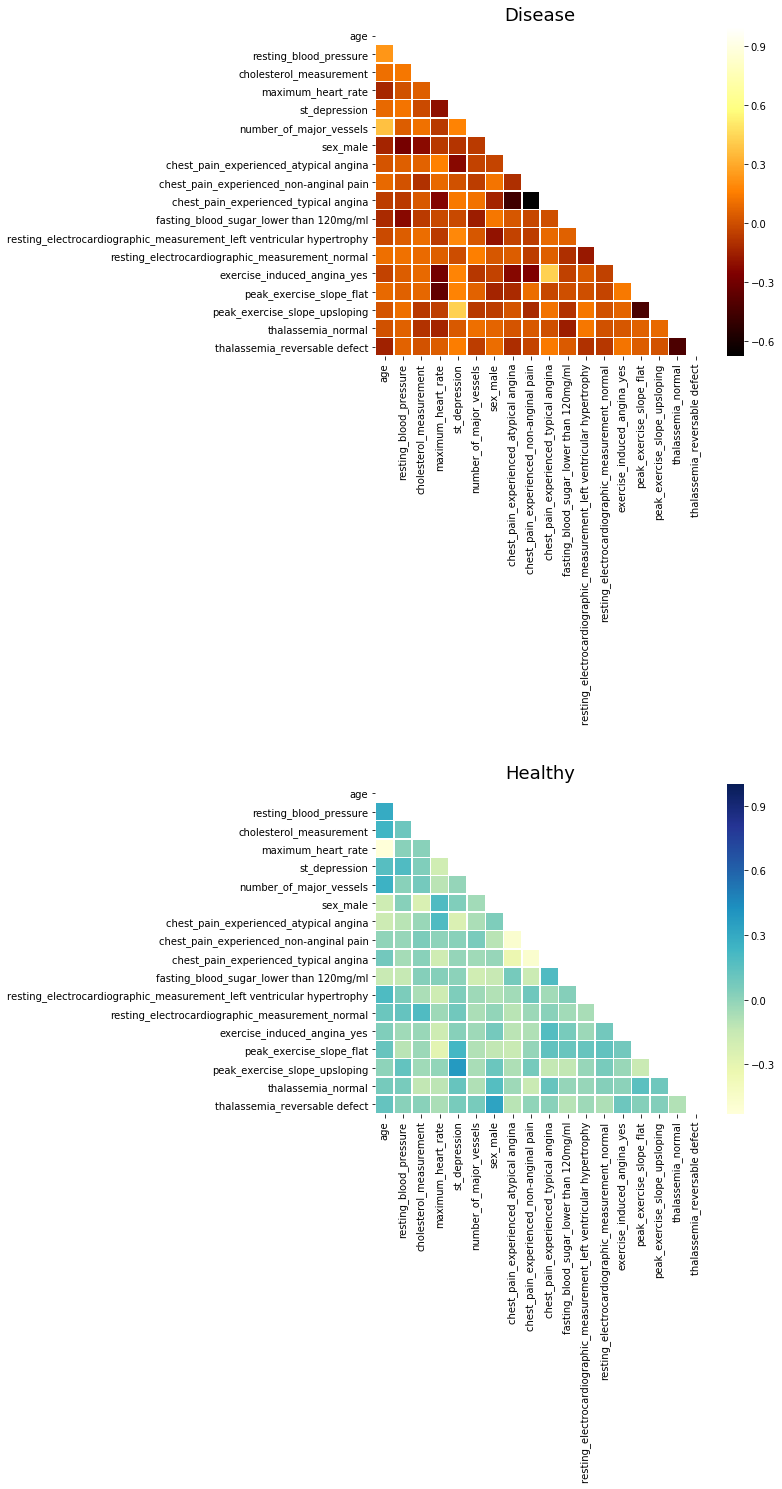

In [6]:
f, (ax1, ax2) = plt.subplots(2,1,figsize =(8, 20))
corr = data_final[X_NAME].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots_adjust(hspace=1.3)
sns.heatmap((data_final[X_NAME][data_final[Y_NAME] ==1]).corr(), square=True, 
            ax = ax2, cmap='YlGnBu', mask=mask, linewidths=.5);
ax1.set_title('Disease', fontsize=18)
sns.heatmap((data_final[X_NAME][data_final[Y_NAME] ==0]).corr(), square=True, 
            ax = ax1, cmap='afmhot', mask=mask, linewidths=.5);
ax2.set_title('Healthy', fontsize=18)
plt.show()

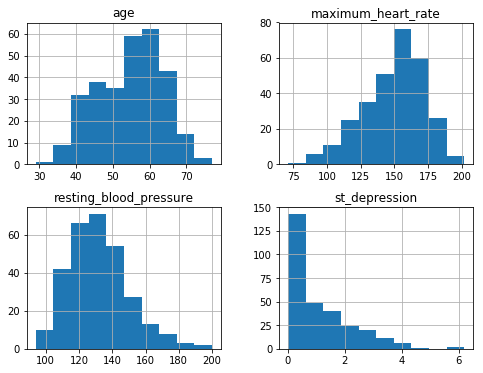

In [7]:
fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace=2)
ax = fig.gca()
data[['age', 'maximum_heart_rate', 'resting_blood_pressure', 'st_depression']].hist(ax=ax)
plt.show()

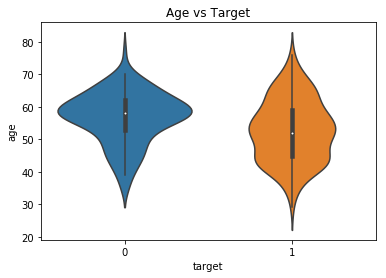

In [8]:
sns.violinplot(data=data, x='target', y='age')
plt.title('Age vs Target')
plt.show()

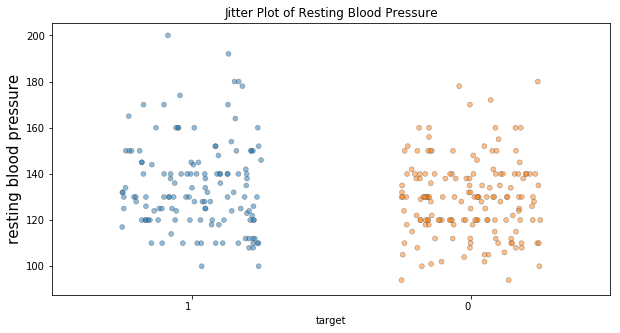

In [9]:
fig, ax = plt.subplots(figsize = (10,5))
sns.stripplot(data['target'], data['resting_blood_pressure'],  jitter=0.25, 
              size=5, ax=ax, linewidth=.5, alpha = 0.5)
ax.set_xticklabels(data.target.unique(), horizontalalignment='right')
ax.set_ylabel('resting blood pressure', fontsize = 15)
ax.set_title('Jitter Plot of Resting Blood Pressure')
plt.show()

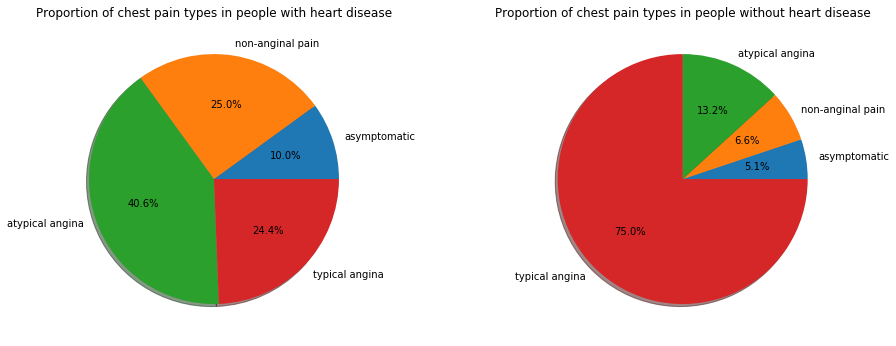

In [133]:
data_target1=data[data.target==1]
data_target0=data[data.target==0]

def B0(data):
    df1 = data[['chest_pain_experienced', 'target']]
    df2 = df1.groupby('chest_pain_experienced').size().reset_index()
    df2.columns = ['chest_pain_experienced', 'number_of_people']
    df2['percentage'] = df2['number_of_people'] * 100 / sum(df2.number_of_people)
    return df2

chest_pain_type_Percentage_t1 = B0(data=data_target1)
chest_pain_type_Percentage_t0 = B0(data=data_target0)
label = data['chest_pain_experienced'].drop_duplicates()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,20))
plt.subplots_adjust(wspace=0.5)
ax1.pie(chest_pain_type_Percentage_t1['number_of_people'], shadow = True, 
        labels = label, autopct='%1.1f%%')
ax1.set_title('Proportion of chest pain types in people with heart disease')
ax2.pie(chest_pain_type_Percentage_t0['number_of_people'], shadow = True, 
        labels = label, autopct='%1.1f%%')
ax2.set_title('Proportion of chest pain types in people without heart disease')
plt.show()

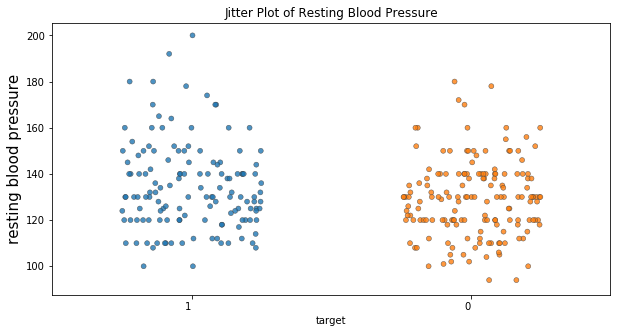

In [122]:
fig, ax = plt.subplots(figsize = (10,5))
sns.stripplot(data['target'], data['resting_blood_pressure'],  jitter=0.25, 
              size=5, ax=ax, linewidth=.5, alpha = 0.8)
ax.set_xticklabels(data.target.unique(), horizontalalignment='right')
ax.set_ylabel('resting blood pressure', fontsize = 15)
ax.set_title('Jitter Plot of Resting Blood Pressure')
plt.show()

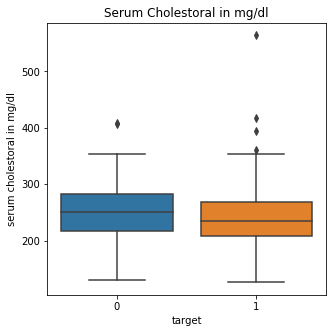

In [123]:
fig, ax = plt.subplots(figsize = (5,5))
sns.boxplot(data['target'], data['cholesterol_measurement'])
ax.set_ylabel('serum cholestoral in mg/dl')
ax.set_xlabel('target')
ax.set_title('Serum Cholestoral in mg/dl')
plt.show()

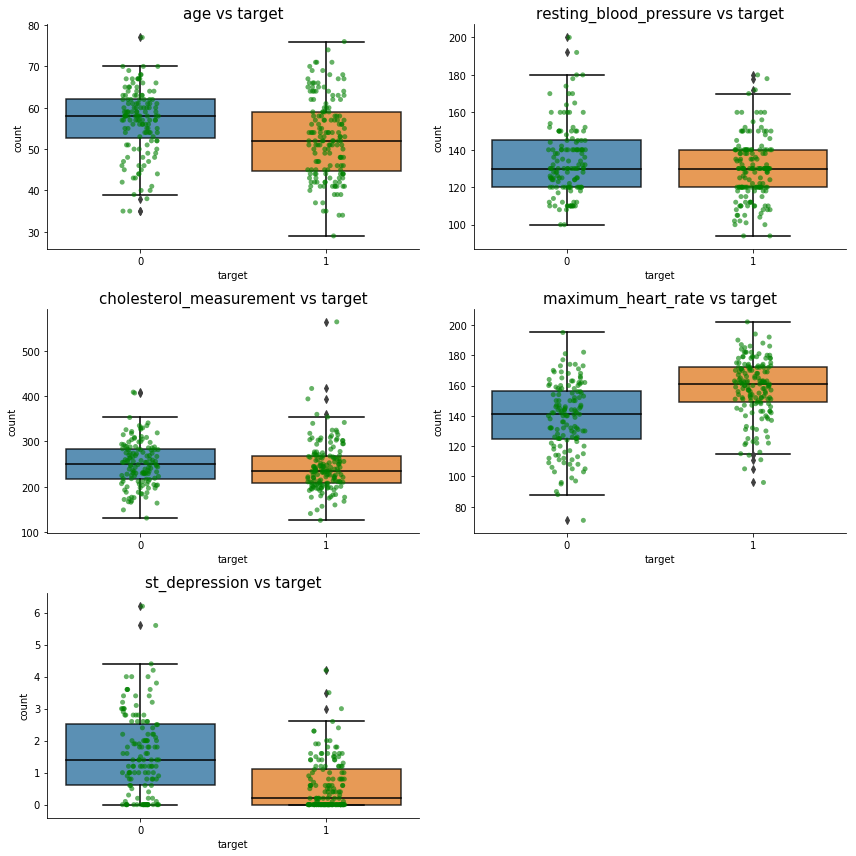

In [131]:
f,ax=plt.subplots(3,2,figsize=(12,12))
f.delaxes(ax[2,1])
for i,feature in enumerate(['age','resting_blood_pressure','cholesterol_measurement','maximum_heart_rate','st_depression']):
    sns.boxplot(x='target', y=feature, data=data , ax=ax[i//2,i%2], 
                boxprops=dict(alpha=0.8))
    sns.stripplot(y=feature, x='target', data=data, ax=ax[i//2,i%2], 
                  jitter=True, marker='o', alpha=0.6, color='g')
    sns.despine()
    ax[i//2,i%2].set_title(str(feature)+' '+'vs'+' '+'target', fontsize=15)
    ax[i//2,i%2].set_ylabel("count")
    ax[i//2,i%2].set_xlabel('target')

    plt.setp(ax[i//2,i%2].artists, edgecolor = 'black')
    plt.setp(ax[i//2,i%2].lines, color='black')

plt.tight_layout()
plt.show()

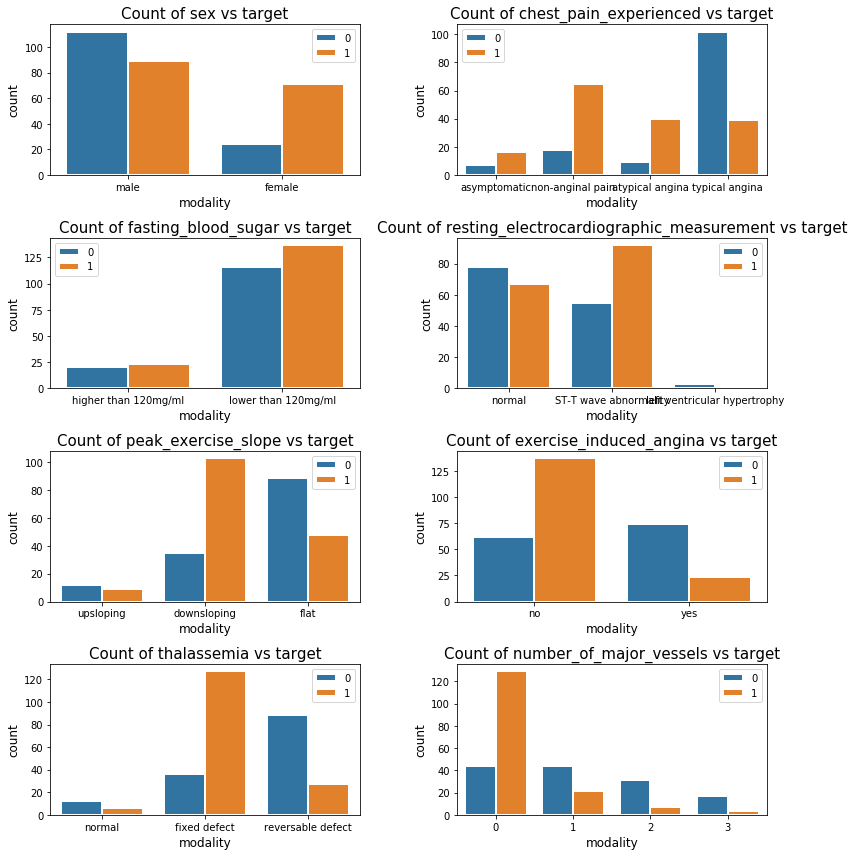

In [19]:
f, ax = plt.subplots(4,2,figsize=(12,12))
for i,feature in enumerate(['sex','chest_pain_experienced','fasting_blood_sugar',
                            'resting_electrocardiographic_measurement','peak_exercise_slope',
                            'exercise_induced_angina','thalassemia','number_of_major_vessels']):
    sns.countplot(x=feature,data=data,hue='target',ax=ax[i//2,i%2], 
                  edgecolor=('white'), linewidth=2)
    ax[i//2,i%2].set_title('Count of {} vs target'.format(feature), fontsize=15)
    ax[i//2,i%2].legend(loc='best')
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('modality', fontsize=12)

plt.tight_layout()
plt.show()

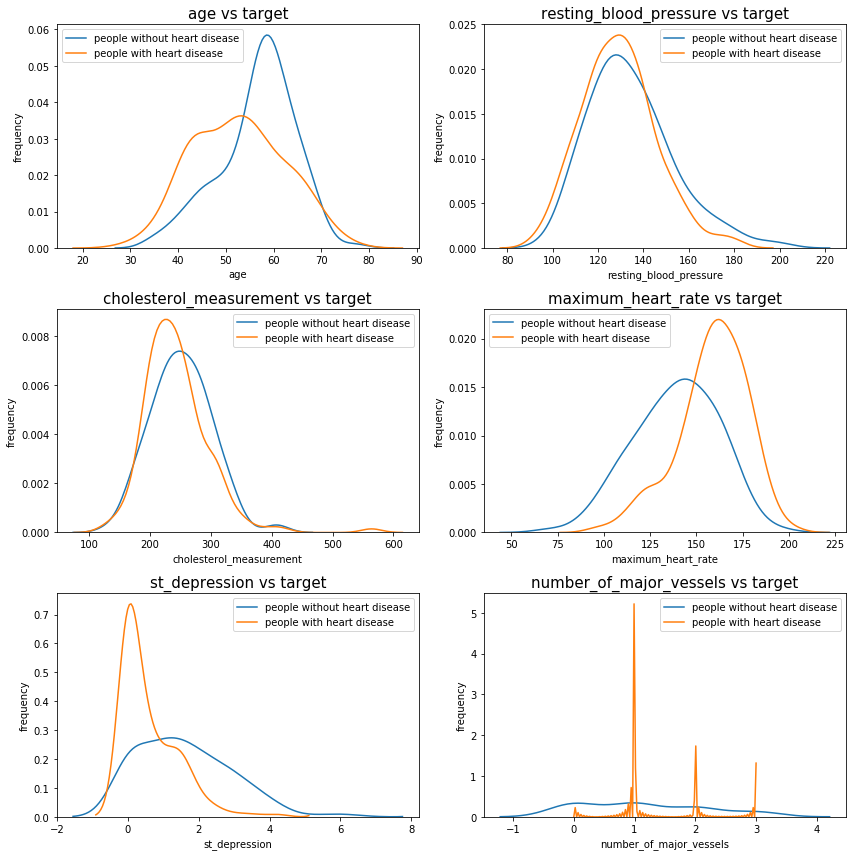

In [111]:
f,ax=plt.subplots(3,2,figsize=(12,12))
for i,feature in enumerate(['age','resting_blood_pressure','cholesterol_measurement',
                            'maximum_heart_rate','st_depression',"number_of_major_vessels"]):
    sns.distplot(data[data['target']==0][(feature)],ax=ax[i//2,i%2],hist = False,kde = True,
                 rug = False, label = "people without heart disease")
    sns.distplot(data[data['target']==1][(feature)],ax=ax[i//2,i%2],hist = False,kde = True,
                 rug = False, label = 'people with heart disease')
    ax[i//2,i%2].set_title('{} vs target'.format(feature), fontsize=15)
    ax[i//2,i%2].set_ylabel("frequency")
    ax[i//2,i%2].set_xlabel(str(feature))
plt.tight_layout()
plt.show()

In [106]:
abs(np.array(range(-15,15,3)))

array([15, 12,  9,  6,  3,  0,  3,  6,  9, 12])

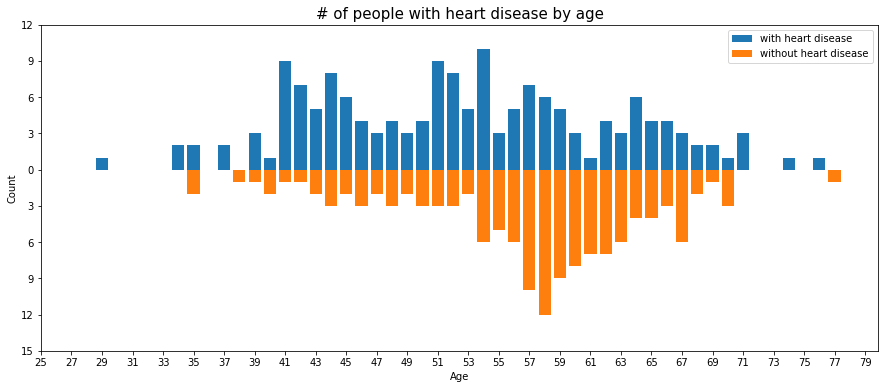

In [115]:
df4 = data.groupby(['age', 'target'])['st_depression'].count().reset_index(name="count")
plt.subplots(figsize = (15, 6))
plt.bar(df4[df4["target"]==1]['age'], df4[df4["target"]==1]['count'], label='with heart disease')
plt.bar(df4[df4["target"]==0]['age'], -df4[df4["target"]==0]['count'], label='without heart disease')
plt.xticks(range(25,80,2))
plt.yticks(range(-15,15,3))
plt.yticks(range(-15,15,3), abs(np.array(range(-15,15,3))))
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.title('# of people with heart disease by age',fontsize=15)
plt.show()

### Step Three. Model Application

__1. Split Data__

In [7]:
def df_to_matrix(df, random_state=42):
    # convert dataframe in matrix format
    y = df[Y_NAME]
    X = df[X_NAME]
    return dict(zip(['X_train', 'X_test', 'y_train', 'y_test'],
                     train_test_split(X, y, test_size=0.2, random_state=random_state)))

ds = df_to_matrix(data_final, random_state=RANDOM_SEED)
print(data_final[X_NAME].shape)
print(np.mean(data_final[Y_NAME]))

(296, 18)
0.5405405405405406


__2. Set Model and Hyperparameters__

In [8]:
model_param_dict = {
    'KNeighborsClassifier': {
        'n_neighbors': range(1, 4)
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'SVC': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100], 
        'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'DecisionTreeClassifier': {
        'max_depth': range(1, 5),
        'max_features': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
        'max_leaf_nodes': range(2, 10),
        'min_samples_leaf': range(2, 10)
    },
    'RandomForestClassifier': {
        'n_estimators': [20, 40, 60, 80, 100, 120],
        'max_depth': range(1, 5),
        'max_features': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
        'max_leaf_nodes': range(2, 10),
        'min_samples_leaf': range(2, 10)
    },
    'GradientBoostingClassifier':{
        'n_estimators':[20, 40, 60, 80, 100, 120], 
        'max_depth':range(1, 6), 
        'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    }
}

__3. Train Model and Report Predicting Performance__

In [11]:
def evaluate_model(model_param_dict, ds, display_val=False):
    # sort and display the test score of all models
    score_list = []
    model_dict = {}
    print('[Best params]')
    for model_name in list(model_param_dict.keys()):
        model = Model(model_name, RANDOM_SEED)
        param_grid = model_param_dict[model_name]
        model.grid_search(param_grid, ds, display_val=display_val)
        score_list.append(model.get_test_score(ds))
        model_dict[model.get_name()] = model.get_model()
    
    # create the ranking table
    score_df = pd.DataFrame(columns=['Model', 'Score on Testing Set', 'Score on Training Set'], data=score_list)
    score_df.sort_values('Score on Testing Set', inplace=True, ascending=False)
    score_df.reset_index(drop=True, inplace=True)
    return score_df, model_dict

rank, model_dict = evaluate_model(model_param_dict=model_param_dict, ds=ds, display_val=True)
rank

[Best params]


KNeighborsClassifier: {'n_neighbors': 3}                            
                           rank_test_score mean_test_score n_neighbors
2                                        1        0.800847           3
0                                        2        0.741525           1
1                                        2        0.741525           2

LogisticRegression: {'C': 0.01}                       
                  rank_test_score mean_test_score      C
1                               1        0.843220   0.01
4                               2        0.830508     10
5                               2        0.830508    100
0                               4        0.826271  0.001
2                               4        0.826271    0.1

SVC: {'gamma': 0.001, 'C': 1}                            
                 rank_test_score mean_test_score    C  gamma
18                             1        0.834746    1  0.001
19                             2        0.826271    1   0.01
30                             2        0.826271  100  0.001
25                             2        0.826271   10   0.01
24                             5        0.822034   10  0.001

DecisionTreeClassifier: {'min_samples_leaf': 6, 'max_leaf_nodes': 8, 'max_features': 0.3, 'max_depth': 4}  \
                                                                                             rank_test_score   
25                                                  1                                                          
4                                                   2                                                          
28                                                  3                                                          
14                                                  4                                                          
13                                                  5                                                          

                                                                           
   mean_test_score max_depth max_features max_leaf_nodes min_samples_leaf  
25        0.796610         4          0.3              8                6  
4         0.766949         3          0.4              5                8  
28        0.758475         3          0.2              5                7  
14        0.737288         4          0.2              5                8  
13        0.728814         1          0.4              6                2

RandomForestClassifier: {'n_estimators': 40, 'min_samples_leaf': 2, 'max_leaf_nodes': 9, 'max_features': 0.4, 'max_depth': 3}  \
                                                                                                                 rank_test_score   
3                                                   1                                                                              
8                                                   2                                                                              
18                                                  2                                                                              
19                                                  4                                                                              
11                                                  5                                                                              

                                                                       \
   mean_test_score n_estimators max_depth max_features max_leaf_nodes   
3         0.838983           40         3          0.4              9   
8         0.834746          100         3          0.4              9   
18        0.834746           80         4          0.3              9   
19        0.826271           40         4          0.2              5   
11        0.822034          120         3          0.2              8   

                     
   min_samples_leaf  
3                 2  
8                 2  
18                8  
19                3  
11                5

GradientBoostingClassifier: {'n_estimators': 60, 'max_depth': 1, 'learning_rate': 0.2}  \
                                                                          rank_test_score   
7                                                   1                                       
10                                                  2                                       
18                                                  2                                       
21                                                  2                                       
37                                                  5                                       

                                                         
   mean_test_score n_estimators max_depth learning_rate  
7         0.834746           60         1           0.2  
10        0.822034           40         3           0.6  
18        0.822034           20         1           0.6  
21        0.822034           60         2           0.6  
37        0.817797           40         3           0.3

,Model,Score on Testing Set,Score on Training Set
0,RandomForestClassifier,0.867,0.839
1,GradientBoostingClassifier,0.867,0.835
2,LogisticRegression,0.850,0.843
3,SVC,0.850,0.835
4,KNeighborsClassifier,0.800,0.801
5,DecisionTreeClassifier,0.683,0.797


__4. Tree Structure and Feature Importance__

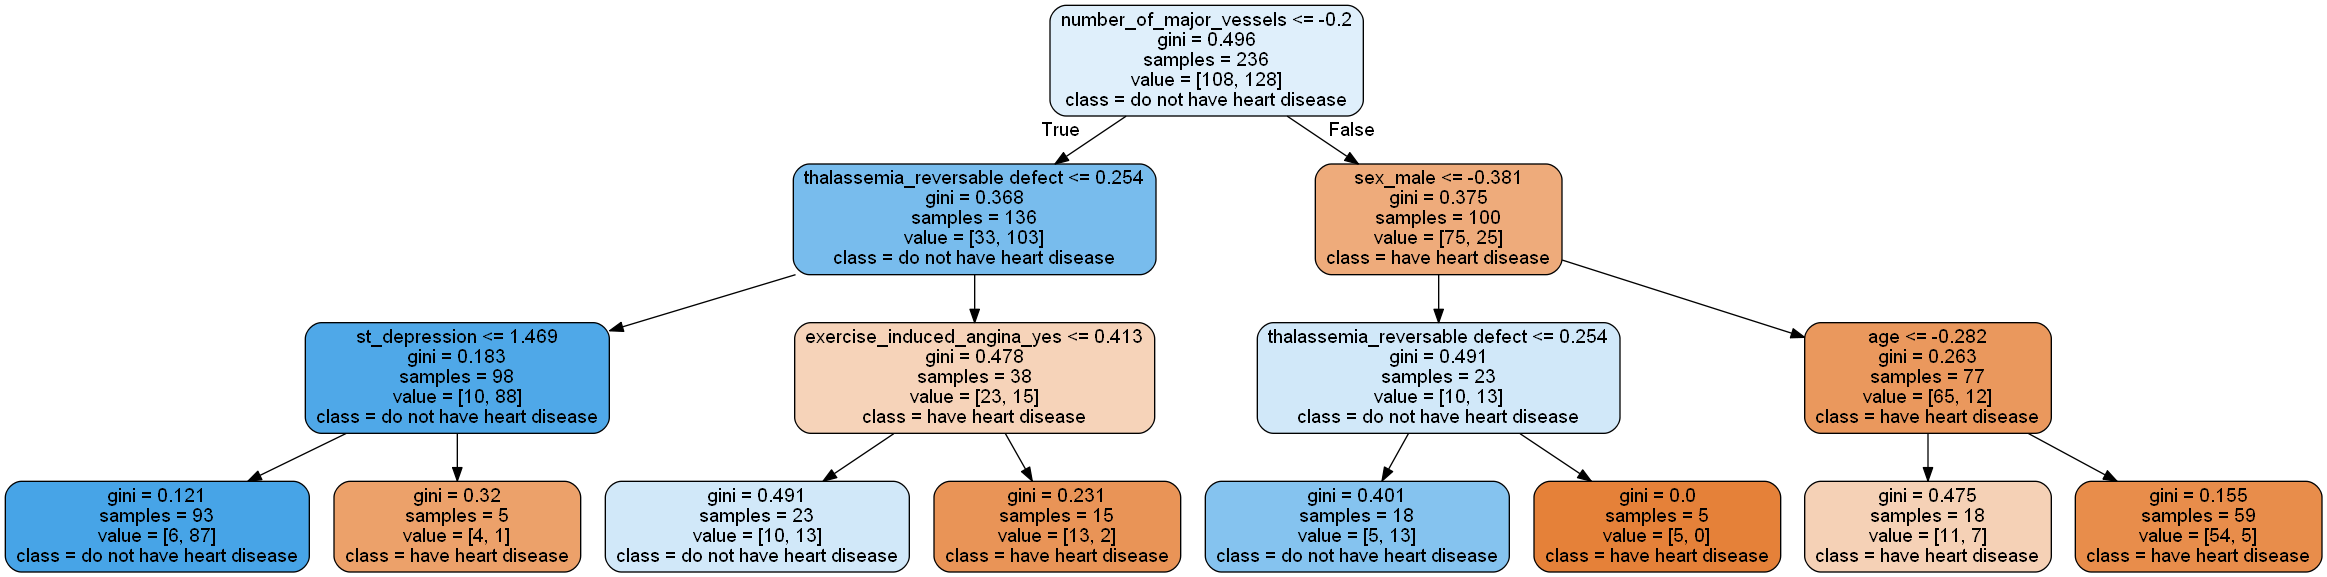

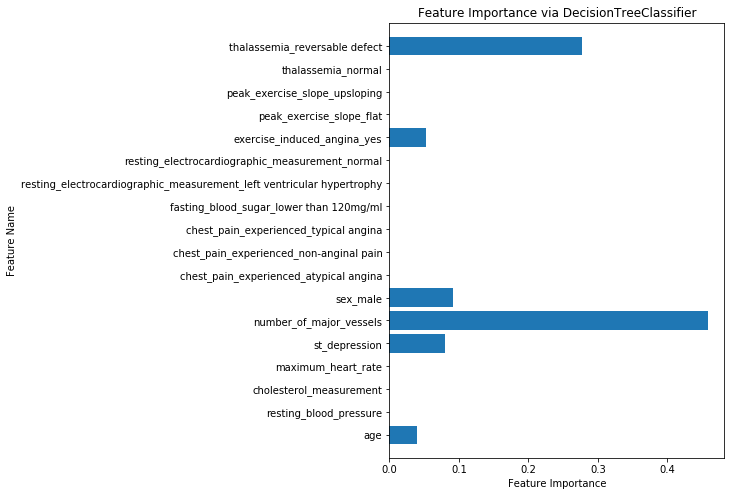

In [135]:
def plot_feature_importances_dt(model, ds):
    treemodel = model.steps[1][1]
    dot_graph = tree.export_graphviz(treemodel, out_file=None, 
                                     class_names=["have heart disease", "do not have heart disease"],
                                     feature_names=X_NAME, filled=True, rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_graph)  
    display(Image(graph.create_png()))
    
    n_features = len(X_NAME)
    plt.figure(figsize=(6, 8))
    plt.barh(range(n_features), treemodel.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_NAME)
    plt.title('Feature Importance via DecisionTreeClassifier')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.ylim(-1, n_features)
    plt.show()

if 'DecisionTreeClassifier' in list(model_dict.keys()):
    plot_feature_importances_dt(model_dict['DecisionTreeClassifier'], ds)

__5. Random Forest Feature Importance__

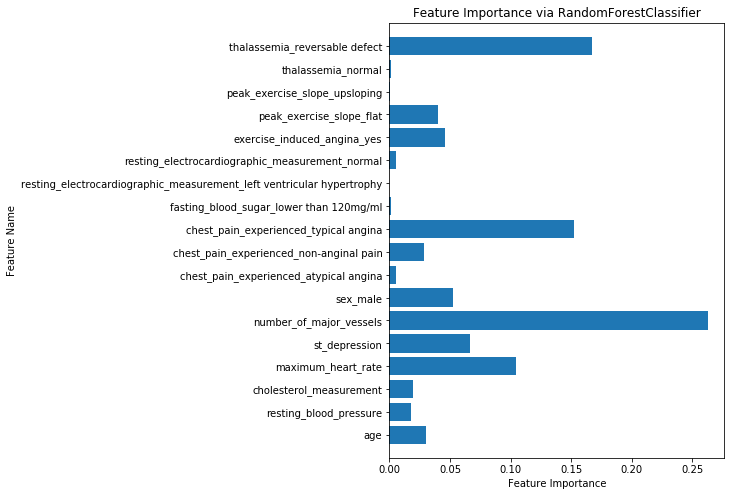

In [136]:
def plot_feature_importances_rf(model):
    n_features = len(X_NAME)
    plt.figure(figsize=(6, 8))
    plt.barh(range(n_features), model.steps[1][1].feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_NAME)
    plt.title('Feature Importance via RandomForestClassifier')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.ylim(-1, n_features)
    plt.show()

if 'RandomForestClassifier' in list(model_dict.keys()):
    plot_feature_importances_rf(model_dict['RandomForestClassifier']) 

__6. Gradient Boosting Feature Importance__

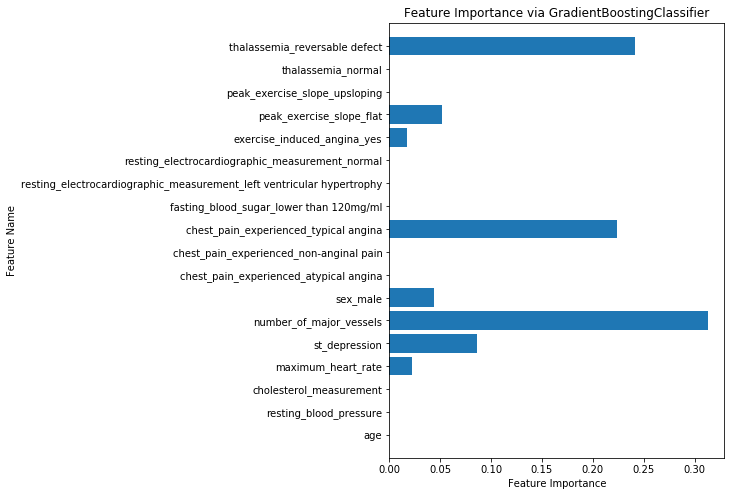

In [10]:
def plot_feature_importances_gbrt(model):
    n_features = len(X_NAME)
    plt.figure(figsize=(6, 8))
    plt.barh(range(n_features), model.steps[1][1].feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_NAME)
    plt.title('Feature Importance via GradientBoostingClassifier')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.ylim(-1, n_features)
    plt.show()

if 'GradientBoostingClassifier' in list(model_dict.keys()):
    plot_feature_importances_gbrt(model_dict['GradientBoostingClassifier']) 

## Part IV. Summary
- Grid-search helps us find the optimal hyperparameters of each model.
- Combining models - random forest and gradient boosting classifier - get great predictions.
- Curious about how to further improve model accuracy.